# Precision-recall curves and Spearman correlation on ScRNA-seq

Nuha BinTayyash, 2020

This notebook shows the precision-recall curves and Spearman correlation scores resulted from running [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package and GPcounts one sample test with negative binomial and Gaussian likelihoods on ScRNA-seq gene expression data in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import stats
from IPython.display import display

\* Note that all negative log likelihood ratios are set to zero

In [2]:
DESeq2 = pd.read_csv('../data/alpha_DESeq2.csv',index_col=[0])

GPcounts_NB = pd.read_csv('../data/ll_Negative_binomial_normalized_alpha_counts.csv',index_col=[0])
GPcounts_G = pd.read_csv('../data/ll_Gaussian_normalized_alpha_counts.csv',index_col=[0])
print(DESeq2.shape)
print(GPcounts_NB.shape)
print(GPcounts_G.shape)

(18274, 6)
(18274, 5)
(18274, 5)


Remove NaNs from DESeq2 results 

In [3]:
nan_gene = list(DESeq2[DESeq2['padj'].isnull()].index.values)
DESeq2 = DESeq2.drop(nan_gene)
DESeq2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000001,123.914854,-1.450563,0.332834,20.681661,0.000005,0.000102
ENSMUSG00000000028,8.918803,-4.498371,1.855694,6.261511,0.012339,0.069156
ENSMUSG00000000031,0.515605,0.154787,1.565667,0.005131,0.942894,0.984825
ENSMUSG00000000037,1.468900,-2.194759,2.309940,1.013488,0.314069,0.606066
ENSMUSG00000000049,0.479602,-4.598312,4.380796,1.909780,0.166988,0.425824


In [4]:
GPcounts_NB = GPcounts_NB.drop(nan_gene)
GPcounts_NB

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000000001,-1881.853140,-1889.872765,8.019625e+00,0:00:27.951184,0:00:27.951184
ENSMUSG00000000028,-315.542880,-317.141326,1.598446e+00,0:00:06.310405,0:00:06.310405
ENSMUSG00000000031,-173.025400,-173.025399,-6.394481e-07,0:00:12.981984,0:00:12.981984
ENSMUSG00000000037,-169.375683,-169.375610,-7.238429e-05,0:00:03.205119,0:00:03.205119
ENSMUSG00000000049,-50.358628,-51.346195,9.875676e-01,0:00:10.078325,0:00:10.078325
...,...,...,...,...,...
ENSMUSG00000102059,-694.107926,-699.604032,5.496106e+00,0:00:07.663619,0:00:07.663619
ENSMUSG00000102070,-2507.327412,-2532.843057,2.551565e+01,0:00:56.067115,0:00:56.067115
ENSMUSG00000102097,-341.138502,-341.138489,-1.363782e-05,0:00:06.784595,0:00:06.784595
ENSMUSG00000102101,-579.920745,-579.963340,4.259545e-02,0:00:04.172762,0:00:04.172762


In [5]:
GPcounts_G = GPcounts_G.drop(nan_gene)
GPcounts_G.head()

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000000001,-644.626648,-664.894774,20.268126,0:00:00.672594,0:00:00.672594
ENSMUSG00000000028,-530.182918,-537.163379,6.980461,0:00:00.707086,0:00:00.707086
ENSMUSG00000000031,-220.366869,-220.366865,-0.000004,0:00:01.070641,0:00:01.070641
ENSMUSG00000000037,-371.064821,-372.013518,0.948697,0:00:00.813669,0:00:00.813669
ENSMUSG00000000049,-130.688464,-131.857033,1.168569,0:00:00.796342,0:00:00.796342


#### label genes as differentially expressed using DESeq2 padj score

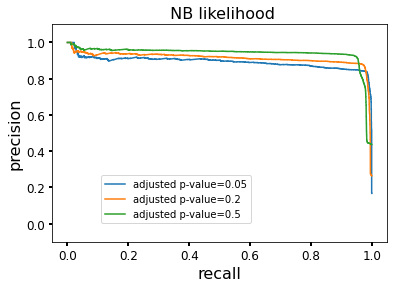

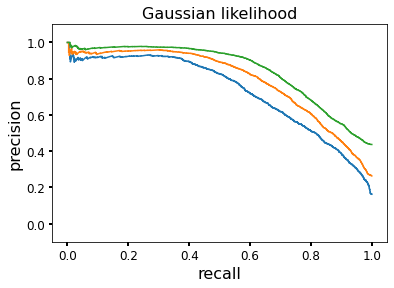

In [6]:
padj = [.05,.2,.5] # Threshold  
fig = plt.figure()

dfs = [GPcounts_NB['log_likelihood_ratio'],GPcounts_G['log_likelihood_ratio']]

for df in range(len(dfs)):
    D = len(DESeq2)
    for i in range(3):
        true_label = np.zeros(D)
  
        for j in range(D):
            # label gene as differentially expressed if DESeq2 give it a score lower than the threshold
            if DESeq2['padj'][j] <= padj[i]:
                true_label[j] = 1 
        labels = pd.DataFrame(true_label, index =DESeq2.index.values, columns =['label'])
        
        precision, recall, thresholds = metrics.precision_recall_curve(labels['label'],dfs[df])

        plt.plot( recall,precision,label='adjusted p-value='+str(padj[i]))
        plt.tick_params(labelsize='large', width=2) 
        
        plt.xlabel('recall',fontsize=16)
        plt.ylabel('precision', fontsize=16)
        
        if df == 0:
            plt.legend(loc='best', bbox_to_anchor=(.61, .33))
            title = ' NB likelihood'
        
        
        else:
            title = 'Gaussian likelihood'
            
        plt.title(title,fontsize=16)
        plt.ylim([-.1,1.1])
        
    plt.show()


### Corrolate DESeq2 with GPcounts with NB likelihood

DESeq2 and GPcounts with NB likelihood identify similar top 4 genes

In [7]:
DESeq_sorted = DESeq2.sort_values(by=['padj'])
display(DESeq_sorted.head())
GPcounts_NB_sorted = GPcounts_NB.sort_values(by=['log_likelihood_ratio'], ascending=False)
display(GPcounts_NB_sorted.head())
GPcounts_G_sorted = GPcounts_G.sort_values(by=['log_likelihood_ratio'], ascending=False)
display(GPcounts_G_sorted.head())

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000394,338406.987012,2.924096,0.092345,848.511483,1.531699e-186,2.419165e-182
ENSMUSG00000023944,1336.307294,-1.948810,0.085680,574.353175,6.344396e-127,5.010170e-123
ENSMUSG00000040856,21.171989,-11.540402,0.489058,424.702760,2.311257e-94,1.216800e-90
ENSMUSG00000021270,380.144931,-2.526495,0.137592,376.412803,7.515536e-84,2.967509e-80
ENSMUSG00000027419,4779.955765,1.505738,0.076123,356.010722,2.080899e-79,6.573143e-76


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000000394,-4232.727238,-4451.319811,218.592574,0:01:49.648120,0:01:49.648120
ENSMUSG00000023944,-2420.025906,-2587.829498,167.803592,0:01:04.334982,0:01:04.334982
ENSMUSG00000021270,-2124.868259,-2251.067250,126.198992,0:00:33.110583,0:00:33.110583
ENSMUSG00000040856,-774.292820,-897.341162,123.048342,0:00:09.087779,0:00:09.087779
ENSMUSG00000027447,-2404.911996,-2526.954625,122.042630,0:00:59.532359,0:00:59.532359


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000040856,-401.654335,-670.424716,268.770381,0:00:00.413818,0:00:00.413818
ENSMUSG00000000394,-134.555066,-367.598795,233.043729,0:00:00.669615,0:00:00.669615
ENSMUSG00000071178,-507.110419,-731.253290,224.142871,0:00:00.513137,0:00:00.513137
ENSMUSG00000073530,-584.842368,-779.125533,194.283165,0:00:00.762755,0:00:00.762755
ENSMUSG00000028415,-516.392946,-705.023732,188.630786,0:00:00.538635,0:00:00.538635


In [8]:
percentage = np.array(list(range(1,11)))
percentage = percentage * .10 # cut a percentage from the dataset
# index of genes ranked by padj from DESeq2
DESeq_index = list(DESeq_sorted.index.values) 
# index of genes ranked by log likelihood ratio from GPcounts with NB likelihood
GPcounts_NB_index = list(GPcounts_NB_sorted.index.values) 
# index of genes ranked by log likelihood ratio from GPcounts with Gaussian likelihood
GPcounts_G_index = list(GPcounts_G_sorted.index.values)

corr_NB = [] # correlation score  between DEseq2 rank and GPcounts_NB rank
corr_G = [] # correlation score  between DEseq2 rank and GPcounts_Gaussian rank

for count in range(10):
    print('Correlation score at:'+str(percentage[count])+' of the dataset:')
    # cut a percentage from the indexes
    DESeq_index_part= DESeq_index[int(len(DESeq_index) * .0) : int(len(DESeq_index) * percentage[count])]
    GPcounts_NB_rank_part = []
    GPcounts_G_rank_part = []
    for i in DESeq_index_part:
        # locate gene from DESeq rank in GPcounts rank to correlate ranking
        GPcounts_NB_rank_part.append(GPcounts_NB_index.index(i))
        GPcounts_G_rank_part.append(GPcounts_G_index.index(i))
    
    DESeq_rank_part = list(range(0,len(DESeq_index_part)))
   
    rho, pval = stats.spearmanr(DESeq_rank_part,GPcounts_NB_rank_part)
    print('NB likelihood',rho)
    corr_NB.append(rho)
    
    print('Gaussian likelihood',rho)
    rho, pval = stats.spearmanr(DESeq_rank_part,GPcounts_G_rank_part)
    corr_G.append(rho)
   

Correlation score at:0.1 of the dataset:
NB likelihood 0.9217648625747223
Gaussian likelihood 0.9217648625747223
Correlation score at:0.2 of the dataset:
NB likelihood 0.9221172888050659
Gaussian likelihood 0.9221172888050659
Correlation score at:0.30000000000000004 of the dataset:
NB likelihood 0.9196652290143502
Gaussian likelihood 0.9196652290143502
Correlation score at:0.4 of the dataset:
NB likelihood 0.9196271133559556
Gaussian likelihood 0.9196271133559556
Correlation score at:0.5 of the dataset:
NB likelihood 0.9141770800241902
Gaussian likelihood 0.9141770800241902
Correlation score at:0.6000000000000001 of the dataset:
NB likelihood 0.9187487643162657
Gaussian likelihood 0.9187487643162657
Correlation score at:0.7000000000000001 of the dataset:
NB likelihood 0.9015961174417305
Gaussian likelihood 0.9015961174417305
Correlation score at:0.8 of the dataset:
NB likelihood 0.8776012166828342
Gaussian likelihood 0.8776012166828342
Correlation score at:0.9 of the dataset:
NB likeli

Plot Spearman correlation score with the percentage of the dataset

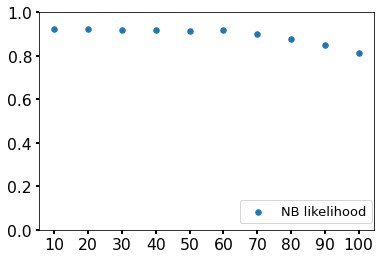

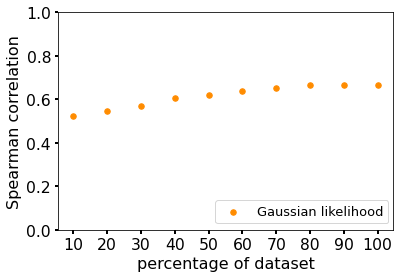

In [9]:
plt.rcParams.update({'font.size': 13})
plt.xticks(percentage*100)
plt.ylim(0.,1.)
plt.tick_params(labelsize='large', width=2)  

plt.scatter(percentage*100,corr_NB,s=30,label = 'NB likelihood')
plt.legend(bbox_to_anchor=(.58, 0), loc='lower left', ncol=1)
plt.show()

plt.xticks(percentage*100)
plt.scatter(percentage*100,corr_G,s=30,color = 'darkorange',label = 'Gaussian likelihood')

plt.xlabel('percentage of dataset', fontsize=16)
plt.ylabel('Spearman correlation', fontsize=16)
plt.ylim(0.,1.)
plt.tick_params(labelsize='large', width=2)  
plt.legend(bbox_to_anchor=(.45, 0), loc='lower left', ncol=1)
plt.show()

In [10]:
percentage = np.array(list(range(1,11)))
percentage = percentage * .10 # cut a percentage from the dataset

# index of genes ranked by log likelihood ratio from GPcounts with NB likelihood
GPcounts_NB_index = list(GPcounts_NB_sorted.index.values) 
# index of genes ranked by log likelihood ratio from GPcounts with Gaussian likelihood
GPcounts_G_index = list(GPcounts_G_sorted.index.values)

corr_G = [] # correlation score  between GPcounts_NB rank and GPcounts_Gaussian rank

for count in range(10):
    print('Correlation score at:'+str(percentage[count])+' of the dataset:')
    # cut a percentage from the indexes
    GPcounts_NB_index_part= GPcounts_NB_index[int(len(GPcounts_NB_index) * .0) : int(len(GPcounts_NB_index) * percentage[count])]
    GPcounts_G_rank_part = []
    
    for i in GPcounts_NB_index_part:
        # locate gene from DESeq rank in GPcounts rank to correlate ranking
        GPcounts_G_rank_part.append(GPcounts_G_index.index(i))
    
    GPcounts_NB_rank_part = list(range(0,len(GPcounts_NB_index_part)))
   

    
    print('Gaussian likelihood',rho)
    rho, pval = stats.spearmanr(GPcounts_NB_rank_part,GPcounts_G_rank_part)
    corr_G.append(rho)
   

Correlation score at:0.1 of the dataset:
Gaussian likelihood 0.6637063814501855
Correlation score at:0.2 of the dataset:
Gaussian likelihood 0.4076591153143077
Correlation score at:0.30000000000000004 of the dataset:
Gaussian likelihood 0.40985357551363616
Correlation score at:0.4 of the dataset:
Gaussian likelihood 0.44514570217158295
Correlation score at:0.5 of the dataset:
Gaussian likelihood 0.4997219663788515
Correlation score at:0.6000000000000001 of the dataset:
Gaussian likelihood 0.543676659170069
Correlation score at:0.7000000000000001 of the dataset:
Gaussian likelihood 0.6405711884851496
Correlation score at:0.8 of the dataset:
Gaussian likelihood 0.6582577565568738
Correlation score at:0.9 of the dataset:
Gaussian likelihood 0.6270101185167318
Correlation score at:1.0 of the dataset:
Gaussian likelihood 0.5741521004741691


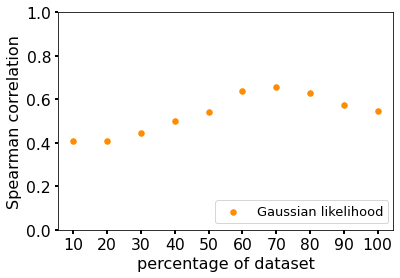

In [11]:
plt.rcParams.update({'font.size': 13})
plt.xticks(percentage*100)
plt.scatter(percentage*100,corr_G,s=30,color = 'darkorange',label = 'Gaussian likelihood')

plt.xlabel('percentage of dataset', fontsize=16)
plt.ylabel('Spearman correlation', fontsize=16)
plt.ylim(0.,1.)
plt.tick_params(labelsize='large', width=2)
plt.legend(bbox_to_anchor=(.45, 0), loc='lower left', ncol=1)
plt.show()